In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
import claude.utils as cu
import claude.tx as ctx
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft

In [3]:
print('Tensorflow version:', tf.__version__)
print('Tensorflow probability version:', tfp.__version__)

Tensorflow version: 1.14.0
Tensorflow probability version: 0.7.0


In [4]:
seed = 42
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 64
chParam.SNR_db = 12

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.temperature = 1
aeParam.nLayersEnc  = 1
aeParam.nLayersDec  = 2
aeParam.nHiddenEnc  = 128
aeParam.nHiddenDec  = 128
aeParam.activation  = tf.nn.relu
aeParam.dtype       = tf.float32
aeParam.cpx_dtype   = tf.complex64

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.nBatches      = 16
trainingParam.batchSize     = 32*chParam.M
trainingParam.learningRate  = 0.001
trainingParam.displayStep   = 5
trainingParam.iterations    = 50

In [5]:
# TF constants
one = tf.constant(1, aeParam.dtype)
twoZeroCpx = tf.constant(2, aeParam.cpx_dtype)

In [6]:
def p_norm(p, x):
    return tf.reduce_sum(p * tf.square(tf.abs(x)))

def r2c(x):
    return tf.cast(x, aeParam.cpx_dtype)

def c2r(x):
    return tf.cast(x, aeParam.dtype)

@tf.custom_gradient
def straight_through_estimator(s_bar):
    s = tf.one_hot(tf.math.argmax(s_bar, axis=-1), chParam.M)
    def grad(dy):
        return dy
    return s, grad

In [7]:
# Sampling
temperature = tf.constant(aeParam.temperature, aeParam.dtype)
SNR_db = tf.placeholder(aeParam.dtype, shape=(1,1))
s_logits = ae._encoder(SNR_db, aeParam.nHiddenEnc, aeParam.nLayersEnc, aeParam.activation, nOutput=chParam.M, name='encoder')
g_dist = tfd.Gumbel(loc=0., scale=1.)
g = g_dist.sample(sample_shape=[trainingParam.batchSize, chParam.M])
s_bar = tf.nn.softmax((g + s_logits)/temperature)

# straight through estimator
s = straight_through_estimator(s_bar)

# normalization & Modulation
p_s = tf.nn.softmax(s_logits)
constellation = tf.constant(ctx.qammod(chParam.M), aeParam.cpx_dtype)
norm_factor = tf.rsqrt(p_norm(p_s, constellation))
norm_constellation = r2c(norm_factor) * constellation
x = r2c(s) @ tf.transpose(norm_constellation) # @ is matmul

# checks
should_always_be_one = p_norm(p_s, norm_constellation)

# Channel
noise_cpx = tf.complex(tf.random_normal(shape=tf.shape(x), dtype=aeParam.dtype),
                       tf.random_normal(shape=tf.shape(x), dtype=aeParam.dtype))
sigma2 = one / cfh.dB2lin(SNR_db, 'dB')
noise_snr = r2c(tf.sqrt(sigma2)) * tf.rsqrt(twoZeroCpx) * noise_cpx

y = x + noise_snr

# demodulator
SNR_db_tile = tf.tile(SNR_db, [trainingParam.batchSize, 1])
y_vec = cfh.complex2real(tf.squeeze(y))
dec_input = tf.concat([y_vec, SNR_db_tile], axis=-1)
dec = ae._encoder(dec_input, aeParam.nHiddenDec, aeParam.nLayersDec, aeParam.activation, nOutput=chParam.M, name='decoder')

W1114 20:20:39.206478 140256600524608 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# loss
loss = tf.nn.softmax_cross_entropy_with_logits(labels=s, logits=dec)
# loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=s, logits=dec) # v2 does not work :(
entropy_S = -tf.reduce_sum(p_s * cfh.log2(p_s))
loss_hat = loss - entropy_S

optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(loss_hat)

metricsDict = {'loss_hat': loss_hat}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

W1114 20:20:39.860960 140256600524608 deprecation.py:323] From <ipython-input-8-a974738f92f8>:2: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

W1114 20:20:40.866911 140256600524608 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [10]:
np_SNR_db = chParam.SNR_db * np.ones((1,1))

for epoch in range(1, trainingParam.iterations+1):
    sess.run(resetOps)
    for batch in range(0,trainingParam.nBatches):
        feedDict = {SNR_db: np_SNR_db}
        sess.run([optimizer, updateOps], feed_dict=feedDict)

    [outLossHat, outShouldAlwaysBeOne] = sess.run([meanMetricOpsDict['loss_hat'], should_always_be_one], feed_dict=feedDict)

    if epoch%trainingParam.displayStep == 0:
        print('epoch: {} - outLossHat: {:.3} - always 1: {:.2}'.format(epoch, outLossHat, outShouldAlwaysBeOne))

epoch: 5 - outLossHat: -2.34 - always 1: 1.0
epoch: 10 - outLossHat: -3.54 - always 1: 1.0
epoch: 15 - outLossHat: -4.13 - always 1: 1.0
epoch: 20 - outLossHat: -4.36 - always 1: 1.0
epoch: 25 - outLossHat: -4.45 - always 1: 1.0
epoch: 30 - outLossHat: -4.5 - always 1: 1.0
epoch: 35 - outLossHat: -4.52 - always 1: 1.0
epoch: 40 - outLossHat: -4.52 - always 1: 1.0
epoch: 45 - outLossHat: -4.52 - always 1: 1.0
epoch: 50 - outLossHat: -4.52 - always 1: 1.0


In [11]:
np_x = []
np_y = []
for _ in range(1000):
    temp_x, temp_y = sess.run([x, y], feed_dict=feedDict)
    np_x.append(temp_x)
    np_y.append(temp_y)

In [12]:
all_y = np.reshape(np.stack(np_y),-1)
all_x = np.reshape(np.stack(np_x),-1)

noise = np.random.normal(0,1,size=all_x.shape)+1j*np.random.normal(0,1,size=all_x.shape) 
all_x = all_x + 0.05*noise

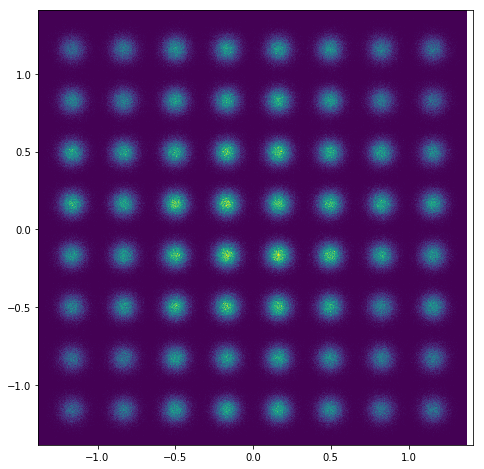

In [13]:
heatmap, xedges, yedges = np.histogram2d(np.real(all_x), np.imag(all_x), bins=500)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.axis('square');